# Script for analysis a ROOT file (a ROOT tree)

### Import libraries, files and etc

Importing PyROOT and libraries

In [136]:
import ROOT
import glob
import numpy as np
import variables as v
from IPython.display import Image, display
import re
# import pandas as pd
from array import array
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"

# Function to display Python output in LaTeX format
from IPython.display import display, Math, Latex
def print_math(string):
    display(Math(string))

Settings and names for analysis

In [137]:
### HERE YOU SHOULD REPLACE filename TO YOUR ROOT FILE! 

N = '0'
path_to_data = 'data/'
filename = N + '_BuToJpsiK'


# BELOW:
#### CMS_picture setting, do not tourch ####

isMC = False
if re.match(r'(\w*)', N).group(0) == 'MC':
    isMC = True
CMS_picture = True


path_png = 'images/png/'
path_pdf = 'images/pdf/'

name = re.findall(r'_(\w*)', filename)[0]
number = f'N-{N}_'

if CMS_picture == True:
    import CMS_style
    CMS_style.extraText = 'Preliminary'
    CMS_style.cmsText = ''
    CMS_style.lumi_13TeV = ''
    CMS_style.lumi_sqrtS = '13 TeV, 2018'
    if isMC:
        CMS_style.extraText = 'Simulation Preliminary'

##### VAR INITIALIZATION

Below we initialize variables we need for analysis.

You should define here all vars from .root file which you need for you analysis.
Name of vars are to be taken from .root file.

In [138]:
#
# __ __ __ __ __ __ __ __ GENERAL STUFF __ __ __ __ __ __ __ __
#
SAMEEVENT            = ROOT.RooRealVar('SAMEEVENT'      , 'SAMEEVENT', -0.5, 1.5)
run                  = ROOT.RooRealVar('run'            ,  'run'     , 100000, 350000)
#
# __ __ __ __ __ __ __ __ PSI VARS __ __ __ __ __ __ __ __
#
B_J_mass_Cmumu       = ROOT.RooRealVar('B_J_mass_Cmumu', 'M(#mu^{+} #mu^{#minus}) [GeV]', 2.9, 4              )
B_J_Prob_Cmumu       = ROOT.RooRealVar('B_J_Prob_Cmumu', 'J/#psi_{vtxprob}'            , 0  , 1               )
#
# __ __ __ __ __ __ __ __ KAON from B VARS __ __ __ __ __ __ __ __
#                    
B_ka_pt              = ROOT.RooRealVar('B_ka_pt'        , 'p_{T}(K^{#minus}) [GeV]', 0 , 300                 )
B_ka_eta             = ROOT.RooRealVar('B_ka_eta'       ,  '#eta(K)'               , -3, 3                   )
#
# __ __ __ __ __ __ __ __ B_meson VARS __ __ __ __ __ __ __ __
#
B_mass_old           = ROOT.RooRealVar('B_mass_old'     , 'M(J/#psiK^{#minus}) [GeV]' , 4.9, 5.7 )
B_pvcos2             = ROOT.RooRealVar('B_pvcos2'  , 'cos (B^{#minus}, PV)'      , -1, 1)
#

### YOU SHOULD ADD MORE VARS WHICH YOU NEED!!!

Creating a dataset **ds_imported** with variables **varset** from a *mytree*in a .root file

In [139]:
file = ROOT.TFile(path_to_data + filename + '.root')

varset = ROOT.RooArgSet(SAMEEVENT, run, B_J_mass_Cmumu, B_J_Prob_Cmumu, ) 

varset.add(ROOT.RooArgSet(B_ka_pt, B_ka_eta, ))

varset.add(ROOT.RooArgSet(B_mass_old, B_pvcos2, ))


ds_importedR = ROOT.RooDataSet('dataR', '', file.Get('mytree_Right'), varset)
ds_importedR.Print()
# ds_importedW = ROOT.RooDataSet('dataW', '', file.Get('mytree_Wrong'), varset)
# ds_importedW.Print()
file.Close()

RooDataSet::dataR[SAMEEVENT,run,B_J_mass_Cmumu,B_J_Prob_Cmumu,B_ka_pt,B_ka_eta,B_mass_old,B_pvcos2] = 203388 entries


### Making cuts, select binning

Creating **cut_summary** from **cuts_list** of each variable

In [140]:
cuts_list = []
cut_jpsi = f'B_J_mass_Cmumu > {v.PDG_JPSI_MASS - 0.1} && B_J_mass_Cmumu < {round(v.PDG_JPSI_MASS + 0.1, 9)}'
cuts_list.append(cut_jpsi)

cuts_list.append('B_ka_pt > 1.5')
cuts_list.append('B_J_Prob_Cmumu > 0.1')
cuts_list.append('B_pvcos2 > 0.99')

## ADD YOUR OWN CUTS HERE
## ADD YOUR OWN CUTS HERE
## ADD YOUR OWN CUTS HERE
## ADD YOUR OWN CUTS HERE


# Create final set of cuts

cut_summary = cuts_list[0]

for a_cut in cuts_list[1:]:
    cut_summary += ' && ' + a_cut
cut_summary

'B_J_mass_Cmumu > 2.9969 && B_J_mass_Cmumu < 3.1969 && B_ka_pt > 1.5 && B_J_Prob_Cmumu > 0.1 && B_pvcos2 > 0.99'

Reducing **ds_imported** with a **cut_summary**, creating **ds_cutted**

Saving our cutted file into **fileOUT** as *TTree*

In [141]:
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.WARNING)

ds_cuttedR = ds_importedR.reduce(cut_summary)
ds_cuttedR.Print()

fileOUT = ROOT.TFile(f'data/cf_{number}_{name}_.root', 'recreate')
ds_cuttedR      .GetClonedTree().Write()
fileOUT.Close()

print(f'Saved to data/cf_{number}_{name}_.root')

Saved to data/cf_N-0__BuToJpsiK_.root
RooDataSet::dataR[SAMEEVENT,run,B_J_mass_Cmumu,B_J_Prob_Cmumu,B_ka_pt,B_ka_eta,B_mass_old,B_pvcos2] = 70728 entries


Select binning for main **binvar** in our dataset: **Nbin** from **bmin** to **bmax**

In [144]:
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.WARNING)

binvar = B_mass_old

bmin = 5.05
bmax = 5.55
    
Nbin = 100

binvar.setMin(bmin)
binvar.setMax(bmax)

cut_binning = f'{binvar.GetName()} > {bmin} && {binvar.GetName()} < {bmax}'

dsR = ds_cuttedR.reduce(cut_binning)
dsR.Print()

ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.INFO) 

RooDataSet::dataR[SAMEEVENT,run,B_J_mass_Cmumu,B_J_Prob_Cmumu,B_ka_pt,B_ka_eta,B_mass_old,B_pvcos2] = 53064 entries


Cell to view the variable **obsvar** after cuts **cut_summary** and binning **cut_binning**

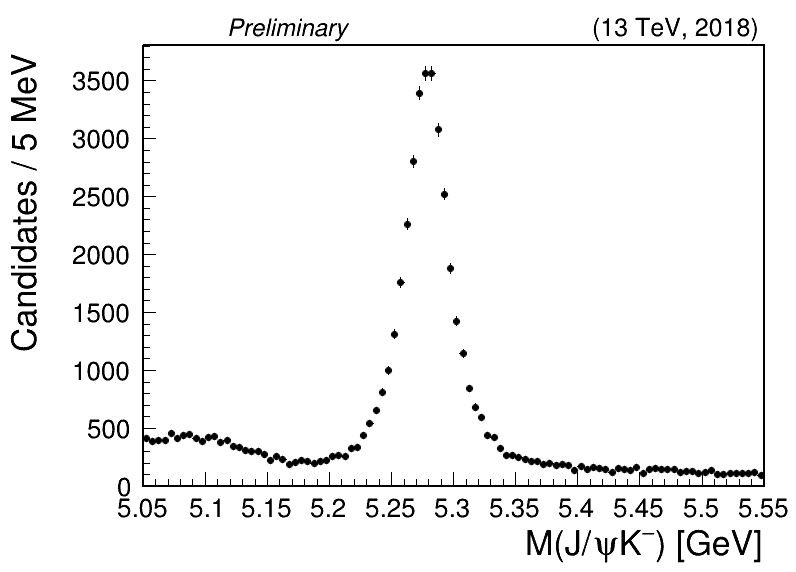

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB
Info in <TCanvas::Print>: png file images/png/test_for_output_ds.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/test_for_output_ds.pdf has been created


In [147]:
# Select var to plot: binvar of another! 
obsvar = binvar
# obsvar = v.B_ka_pt

# Create frame for obsvar. For binvar its range = binvar_range
# If you plot another var please set: obsvar.frame(bin_max, bin_min, Nbin)

bufram = obsvar.frame(Nbin)
# bufram = obsvar.frame(0, 10, Nbin)

ff = v.get_fr_bin(Nbin, obsvar, bufram)

picname = 'test_for_output_ds'
# You may change picname to save picture in folder, see example below:
# picname = f'{obsvar.GetName()}_plot_test'


#### 
#### BELOW PLOT SETTINGS, DO NOT TOUCH ####
####

if CMS_picture == True:
    CMS_style.setTDRStyle()

_MYW = 800
_MYH = 600
_MYT = 0.08 * _MYH
_MYB = 0.15 * _MYH
_MYL = 0.18 * _MYW
_MYR = 0.04 * _MYW

cB = ROOT.TCanvas("cB","cB",_MYW,_MYH)

cB.SetLeftMargin( _MYL/_MYW )
cB.SetRightMargin( _MYR/_MYW )
cB.SetTopMargin( _MYT/_MYH )
cB.SetBottomMargin( _MYB/_MYH )
cB.SetTickx(0)
cB.SetTicky(0)

bufram.GetXaxis().SetTitleOffset(1.0)
bufram.GetYaxis().SetTitleOffset(1.45)
bufram.SetYTitle(f'Candidates / {ff}')

####
####

# Plot Dataset
dsR.plotOn(bufram, ROOT.RooFit.MarkerSize(0.8), ROOT.RooFit.Name('data'), 
          )

bufram.Draw()

## CMS Image settings
if CMS_picture == True:
    CMS_style.CMS_lumi( cB, 0 if isMC == 1 else period, 0 ); ## 2nd argument = 0 for MC
    cB.Update(); cB.RedrawAxis(); # cB.GetFrame().Draw();

cB.SaveAs(f'images/png/{picname}.png')
cB.SaveAs(f'images/pdf/{picname}.pdf')
display(Image(filename = f'images/png/{picname}.png', retina = False, width = 550))

### Creating Fit variables

In [104]:
# Choose var for fit

fitvar = obsvar 

# fitvar = v.XB_mass_Cjp_old

Creating initial variables for fitting and choose fit function

In [105]:
S_mean_0 = 5.28  # initial mean of signal 
S_0 = dsR.numEntries() * 0.5  # initial number of signal events

# limits for number of signal events for fitting
S_upper = dsR.numEntries() * 0.9
S_lower = 0

Gauss = 1 # Choose a fit signal function (number of Gaussians)
bkg_exp = 1 # Fitting backgroung with Exponential function
bkg_bern   = 0  # Fitting backgroung with Bernstein N-order function, N = {1, 4} (0 for no B)

#### Creating Signal variables

In [106]:
###                                                initial  lower   upper
###                                                values   bound   bound

S       = ROOT.RooRealVar ( 'S'      , 'S'  , S_0      , S_lower , S_upper)

S1_mean = ROOT.RooRealVar ( 'S1_mean', 'mean '   , S_mean_0 , S_mean_0-0.2, S_mean_0+0.2)
S1_sigma= ROOT.RooRealVar ( 'S1_sigma','sigma'   , 1.4842e-02   , 0.00000001   , 0.2   )
# S1_sigma= ROOT.RooRealVar ( 'S1_sigma','sigma'   , MC_shape[0], 0.000001   , 0.1   )

pdfS1   = ROOT.RooGaussian( 'pdfS1'  , 'gaus'    , fitvar , S1_mean , S1_sigma)

if Gauss == 2:
    S_f1    = ROOT.RooRealVar ( 'S_f1'   , 'frac'    , 5.5610e-01  , 0.0     , 1.0    )
#     S_f1    = ROOT.RooRealVar ( 'S_f1'   , 'frac'    , MC_shape[2], 0.0     , 1.0    )
    
    S2_sigma= ROOT.RooRealVar ( 'S2_sigma','sigma'   , 7.2827e-03 , 0.000001   , 0.1  )
#     S2_sigma= ROOT.RooRealVar ( 'S2_sigma','sigma'   , MC_shape[1] , 0.000001   , 0.1  )
    
    pdfS2   = ROOT.RooGaussian( 'pdfS2'  , 'gaus'    , fitvar   ,S1_mean, S2_sigma)
    
    pdfSig  = ROOT.RooAddPdf  ('pdfSig', 'pdfSig', ROOT.RooArgList(pdfS1, pdfS2), ROOT.RooArgList(S_f1))
    sigmeff = ROOT.RooFormulaVar ('sigmaeff', 'sigmaeff',
    '((S1_sigma**2)*S_f1 + (S2_sigma**2)*(1- S_f1))**0.5', ROOT.RooArgList(S1_sigma, S2_sigma, S_f1))
    #
    # SCALING DG
    #
    scal    = ROOT.RooRealVar ( 'scal'      , 'scal'  , 1      , 0 , 100)
    S1_sigmaS = ROOT.RooFormulaVar ( 'S1_sigmaS','sigma'   , 'scal * S1_sigma', ROOT.RooArgList(scal, S1_sigma))
    S2_sigmaS = ROOT.RooFormulaVar ( 'S2_sigmaS','sigma'   , 'scal * S2_sigma', ROOT.RooArgList(scal, S2_sigma))
    
    pdfS1S    = ROOT.RooGaussian( 'pdfS1S'  , 'gaus'    , fitvar , S1_mean , S1_sigmaS)
    pdfS2S    = ROOT.RooGaussian( 'pdfS2S'  , 'gaus'    , fitvar , S1_mean , S2_sigmaS)
    
    pdfSigS  = ROOT.RooAddPdf  ('pdfSigS', 'pdfSigS', ROOT.RooArgList(pdfS1S, pdfS2S), ROOT.RooArgList(S_f1))
    sigmeffS = ROOT.RooFormulaVar ('sigmaeffS', 'sigmaeffS',
    '((S1_sigmaS**2)*S_f1 + (S2_sigmaS**2)*(1- S_f1))**0.5', ROOT.RooArgList(S1_sigmaS, S2_sigmaS, S_f1))

elif Gauss == 3:
    S_f1    = ROOT.RooRealVar ( 'S_f1'   , 'frac'    , 0.25  , 0.     , 1.0    )
    S_f2    = ROOT.RooRealVar ( 'S_f2'   , 'frac'    , 0.35  , 0.     , 1.0    )
    S2_sigma= ROOT.RooRealVar ( 'S2_sigma','sigma'   , 1.8458e-03 , 0.000001   , 0.1   )
    S3_sigma= ROOT.RooRealVar ( 'S3_sigma','sigma'   , 4.4623e-03 , 0.000001   , 0.1   )
    S3_mean = ROOT.RooRealVar ( 'S3_mean', 'mean '   , S_mean_0+0.01 , S_mean_0-0.2, S_mean_0+0.2)
    pdfS2   = ROOT.RooGaussian( 'pdfS2'  , 'gaus'    , fitvar   ,S1_mean, S2_sigma)
    pdfS3   = ROOT.RooGaussian( 'pdfS3'  , 'gaus'    , fitvar   ,S3_mean, S3_sigma)
    
    pdfSig  = ROOT.RooAddPdf  ('pdfSig', 'pdfSig', ROOT.RooArgList(pdfS1, pdfS2, pdfS3), ROOT.RooArgList(S_f1, S_f2))
    
    sigmeff = ROOT.RooFormulaVar ('sigmaeff', 'sigmaeff',
    '((S1_sigma**2)*S_f1 + (S2_sigma**2)*S_f1 + (S3_sigma**2)*(1-S_f1-S_f2))**0.5', 
                                  ROOT.RooArgList(S1_sigma, S2_sigma, S3_sigma, S_f1, S_f2))

#### Creating backgroung variables

In [107]:
###                                                 initial  lower   upper
###                                                 values   bound   bound

B           = ROOT.RooRealVar ( 'B'       , 'B'    , dsR.numEntries() * 0.9, 0    , dsR.numEntries() * 1.01 )
if bkg_exp:
    B_c1    = ROOT.RooRealVar ( 'Bg_c1'    , 'B_c1' , -2.5537e+00 , -200   , 200         )
    pdfB    = ROOT.RooExponential('pdfB'  , 'pdfB' , fitvar   , B_c1)

if bkg_bern:  
    B_c     = ROOT.RooRealVar   ( 'B_c'   , 'B_c ' , -2.3  , -20   , 100)
    B_1     = ROOT.RooRealVar   ( 'B_1'   , 'B_1 ' , 0.1   , 0.0   , 1.0)
    B_2     = ROOT.RooRealVar   ( 'B_2'   , 'B_2 ' , 0.1   , 0.0   , 1.0)
    B_3     = ROOT.RooRealVar   ( 'B_3'   , 'B_3 ' , 0.1   , 0.0   , 1.0)
    B_4     = ROOT.RooRealVar   ( 'B_3'   , 'B_3 ' , 0.1   , 0.0   , 1.0)
    BX1     = ROOT.RooFormulaVar( 'BX1'   , 'BX1'  , '1.0 - @0'            , ROOT.RooArgList(B_1))
    BX2     = ROOT.RooFormulaVar( 'BX2'   , 'BX2'  , '1.0 - @0 -@1'        , ROOT.RooArgList(B_1, B_2))
    BX3     = ROOT.RooFormulaVar( 'BX3'   , 'BX3'  , '1.0 - @0 -@1 -@2'    , ROOT.RooArgList(B_1, B_2, B_3))
    BX4     = ROOT.RooFormulaVar( 'BX4'   , 'BX4'  , '1.0 - @0 -@1 -@2 -@3', ROOT.RooArgList(B_1, B_2, B_3, B_4))
    
    if bkg_bern   == 1:
        pdfB    = ROOT.RooBernstein('pdfB', 'pdfB' , fitvar, ROOT.RooArgList(B_1, BX1)) 
    elif bkg_bern == 2:
        pdfB    = ROOT.RooBernstein('pdfB', 'pdfB' , fitvar, ROOT.RooArgList(B_1, B_2, BX2))
    elif bkg_bern == 3:
        pdfB    = ROOT.RooBernstein('pdfB', 'pdfB' , fitvar, ROOT.RooArgList(B_1, B_2, B_3, BX3))
    elif bkg_bern == 4:
        pdfB    = ROOT.RooBernstein('pdfB', 'pdfB' , fitvar, ROOT.RooArgList(B_1, B_2, B_3, B_4, BX4))

#### Creating a final P.D.F. model, ready to fit

In [108]:
if Gauss == 1:
    alist1  = ROOT.RooArgList (pdfS1, pdfB)
else:
    alist1  = ROOT.RooArgList (pdfSig, pdfB)
#     alist1  = ROOT.RooArgList (pdfSigS, pdfB)

alist2  = ROOT.RooArgList (S, B)
pdfSum  = ROOT.RooAddPdf  ('pdfSum', 'pdfSum', alist1, alist2)

### Fitting a model using RooFit

In [109]:
### We fit several times. First, with some paremetrs setConstant(True).
### Then we relese them to be floating 
### It is needed for fit convergence 

S1_sigma.setConstant(True)
if   Gauss == 2:
    S_f1.setConstant(True)
    S2_sigma.setConstant(True)

S1_mean.setConstant(True)

rrr = pdfSum.fitTo(dsR, ROOT.RooFit.NumCPU(2), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
print('1 fit done')

S1_sigma.setConstant(False)
if   Gauss == 2:
    S2_sigma.setConstant(False)

rrr = pdfSum.fitTo(dsR, ROOT.RooFit.NumCPU(2), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
print('2 fit done')

S1_mean.setConstant(False)
rrr = pdfSum.fitTo(dsR, ROOT.RooFit.NumCPU(2), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
print('3 fit done')

if   Gauss == 2:
    S_f1.setConstant(False)

rrr = pdfSum.fitTo(dsR, ROOT.RooFit.NumCPU(2), ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())
rrr.Print()


### This part of the code is needed to calculate chi2/n_dof (hi-kvadrat)
### This part of the code is needed to calculate chi2/n_dof (hi-kvadrat)

mframe = fitvar.frame(Nbin);
dsR.plotOn( mframe, ROOT.RooFit.MarkerSize(0.9), ROOT.RooFit.Name('data'));

pdfSum.plotOn( mframe, ROOT.RooFit.Name('fitt'), ROOT.RooFit.Range(fitvar.getMin(), fitvar.getMax()) )
#pdfSum.plotOn( mframe, RooFit.Name('fitt'), RooFit.Range(5.4, 5.8 ))

H_FITRES = ROOT.TH1F('H_FITRES', 'c2df-ndof-chi2-prob', 4, 1, 5)
FIT_c2df = mframe.chiSquare(rrr.floatParsFinal().getSize() )
FIT_ndof = (Nbin - rrr.floatParsFinal().getSize())
FIT_chi2 = FIT_c2df * FIT_ndof; H_FITRES[3] = FIT_chi2;
H_FITRES[1] = FIT_c2df; H_FITRES[2] = FIT_ndof
H_FITRES[4] = ROOT.TMath.Prob(FIT_chi2, FIT_ndof)

print(f'prob = {round(ROOT.TMath.Prob(FIT_chi2, FIT_ndof), 4)}, chi2/ndof = {round(FIT_chi2, 1)}/{FIT_ndof}')

1 fit done
2 fit done
3 fit done
prob = 0.0, chi2/ndof = 949.9/95
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 2 remote server process.
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (pdfS1)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (pdfB)
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (pdfS1)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (pdfB)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INF

#### Creating variables for results of fit and its display

**sigma_eff** error calculation 

In [114]:
try:
    s1w = (S1_sigma.getVal() ** 2) * S_f1.getVal()
    s2w = (S2_sigma.getVal() ** 2) * (1 - S_f1.getVal())

    df = S_f1.getError()/S_f1.getVal()
    ds1 = S1_sigma.getError()/S1_sigma.getVal()
    ds2 = S2_sigma.getError()/S2_sigma.getVal()

    ds1w = s1w * np.sqrt( df ** 2 + (2 * ds1) ** 2)
    ds2w = s2w * np.sqrt( df ** 2 + (2 * ds2) ** 2)

    dseff2 = np.sqrt(ds1w ** 2 + ds2w ** 2)
    dseff = 1000 * dseff2 / (2 * sigmeff.getVal())

    dseffS = 1000 * (scal.getError() / scal.getVal()) * sigmeffS.getVal()
    dseff
except NameError:
    print('Only single Gaussian now')

Only single Gaussian now


Settings for Significant Digits after comma 

In [115]:
S1_s_r = 1
if 1000 * S1_sigma.getVal() < 10: S1_s_r = 2
if Gauss > 1:
    S2_s_r = 1
    if 1000 * S2_sigma.getVal() < 10: S2_s_r = 2
    S_eff_r = 1
    if 1000 * sigmeff.getVal() < 10: S_eff_r = 2

Create beautiful outputs of our fit

In [125]:
Sign = S.getVal() / S.getError()

Delta_M = (1000 * v.PDG_BU_MASS - 1000 * S1_mean.getVal())
dm_err = np.sqrt((1000 * S1_mean.getError())**2 + 0.07**2)
# dm_err = np.sqrt((1000 * S1_mean.getError())**2 + 0.07**2)

S_str = r'N_{signal}^{B^-} = '+str(round(S.getVal(), 1)) + r'\pm' + str(round(S.getError(), 1))
M_str = r'M_{B^-} = ' + str(round(1000 * S1_mean.getVal(), 2)) + r'\pm' + str(round(1000 * S1_mean.getError(), 2)) + '\; MeV'
sign_str = r'\frac{N_{signal}}{\sigma_N} = ' + str(round(Sign, 2))
delta_str = r'M_{B^-} - M_{B^-}^{PDG}=' + str(round(Delta_M, 2)) + '\; MeV'

S_str_c = 'N_{signal} = ' + str(round(S.getVal(), 1)) + ' #pm ' + str(round(S.getError(), 1))
M_str_c = 'M_{B^{+}} = ' + str(round(1000 * S1_mean.getVal(), 2)) + r' #pm ' + str(round(1000 * S1_mean.getError(), 2)) + ' MeV'
sign_str_c = 'N_{signal} / #sigma_{N_{signal}} = ' + str(round(Sign, 1))     
delta_str_c = 'M_{B^{-}} - M_{B^{-}}^{PDG} = ' + str(round(Delta_M, 2))  + r' #pm ' + str(round(dm_err, 2)) + ' MeV'
sigmaG_str_c = '#sigma_{Gauss} = ' + str(round(1000 * S1_sigma.getVal(), S1_s_r)) + r' #pm ' + str(round(1000 * S1_sigma.getError(), S1_s_r)) + ' MeV'
if Gauss > 1:
    sigmaG_str_c = '#sigma_{eff} = ' + str(round(1000 * sigmeff.getVal(), S_eff_r)) + r' #pm ' + str(round(dseff, S_eff_r)) + ' MeV'
    sigmaG_str_c = '#sigma_{eff} = ' + str(round(1000 * sigmeffS.getVal(), S_eff_r)) + r' #pm ' + str(round(dseffS, S_eff_r)) + ' MeV'

    print(round(1000 * sigmeff.getVal(), 3))


print_math(S_str)
print_math(M_str)
print_math(sign_str + r', \;' + delta_str)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Set settings for canvas to show

In [126]:
# name of fitted plot
_MYcanvName = f'_{number}_{name}_fv={fitvar.GetName()}_'
# _MYcanvName = f'ANv{ANv}_{number}_{name}_fv={fitvar.GetName()}_{y16=}_{y17=}_{y18=}_MCFFix'

if CMS_picture == True:
    CMS_style.setTDRStyle()

cB = ROOT.TCanvas('cB','cB', _MYW, _MYH)

cB.SetLeftMargin( _MYL/_MYW )
cB.SetRightMargin( _MYR/_MYW )
cB.SetTopMargin( _MYT/_MYH )
cB.SetBottomMargin( _MYB/_MYH )
cB.SetTickx(0)
cB.SetTicky(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cB


#### Show results of fit

550.7484821961679


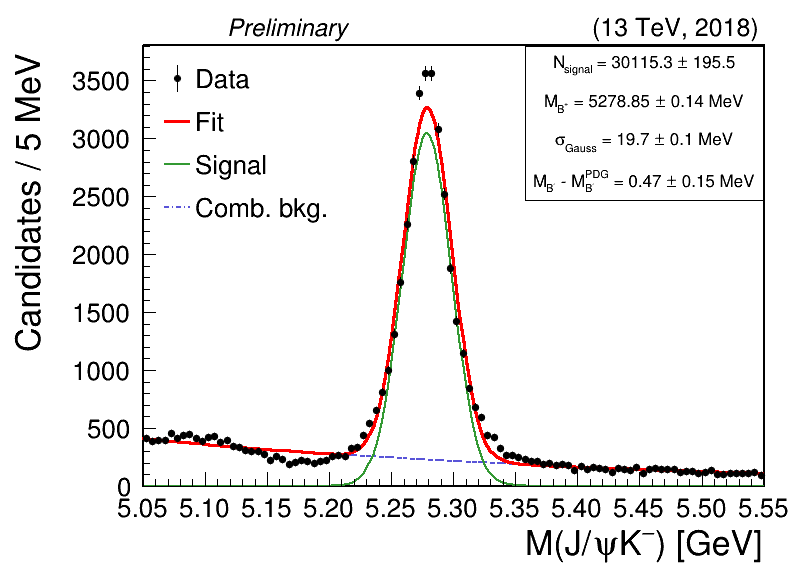

[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdfSum) directly selected PDF components: (pdfB)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdfSum) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdfSum) directly selected PDF components: (pdfS1)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(pdfSum) indirectly selected PDF components: ()
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0525,5.0525)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0575,5.0575)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0625,5.0625)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0675,5.0675)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0725,5.0725)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0775,5.0775)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0825,5.0825)
[#0] ERROR:InputArguments -- RooCurve::average(fit) invalid range (5.0875

Info in <TCanvas::Print>: png file images/png/_N-0__BuToJpsiK_fv=B_mass_old_.png has been created
Info in <TCanvas::Print>: pdf file images/pdf/_N-0__BuToJpsiK_fv=B_mass_old_.pdf has been created


In [127]:
bufram = fitvar.frame(Nbin)
# bufram = v.XI_mass_old.frame(1.28, 1.36, Nbin)
ff = v.get_fr_bin(Nbin, fitvar, bufram)

bufram.GetXaxis().SetTitleOffset(1.0)
bufram.GetXaxis().SetDecimals()
bufram.GetYaxis().SetTitleOffset(1.4)
bufram.SetYTitle(f'Candidates / {ff}')

### Plot dataset
dsR.plotOn(bufram, ROOT.RooFit.MarkerSize(0.8), ROOT.RooFit.Name('data'), ROOT.RooFit.XErrorSize(0))

### Plot our PDF and its components!!! 
### Plot our PDF and its components!!! 

pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfB'),
                            ROOT.RooFit.LineColor(9),
                            ROOT.RooFit.LineStyle(5),
                            ROOT.RooFit.LineWidth(2),
                            ROOT.RooFit.Name('bkgr'))

if Gauss == 1:
    pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfS1'),
                                ROOT.RooFit.LineColor(ROOT.kGreen-2),
                                ROOT.RooFit.LineStyle(1),
                                ROOT.RooFit.LineWidth(2),
                                ROOT.RooFit.Name('sign')
#               ,ROOT.RooFit.Range(S1_mean.getVal()-5.0*sigma_eff, S1_mean.getVal()+5.0*sigma_eff)  
                 )
else:
#     pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfSig'),
#                                 ROOT.RooFit.LineColor(ROOT.kGreen+2),
#                                 ROOT.RooFit.LineStyle(5),
#                                 ROOT.RooFit.LineWidth(2),
#                                 ROOT.RooFit.Name('sign')
# #               ,ROOT.RooFit.Range(S1_mean.getVal()-5.0*sigma_eff, S1_mean.getVal()+5.0*sigma_eff)  
#                  )
#      pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfSig'),
#                                 ROOT.RooFit.LineColor(ROOT.kGreen-2),
#                                 ROOT.RooFit.LineStyle(1),
#                                 ROOT.RooFit.LineWidth(2),
#                                 ROOT.RooFit.Name('sign')
#               ,ROOT.RooFit.Range(S1_mean.getVal()-5.0*sigma_eff, S1_mean.getVal()+5.0*sigma_eff)  
#                  )
     pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfS1'),
                                ROOT.RooFit.LineColor(ROOT.kGreen-2),
                                ROOT.RooFit.LineStyle(1),
                                ROOT.RooFit.LineWidth(2),
                                ROOT.RooFit.Name('sign')
#               ,ROOT.RooFit.Range(S1_mean.getVal()-5.0*sigma_eff, S1_mean.getVal()+5.0*sigma_eff)  
                 )
     pdfSum.plotOn(  bufram,     ROOT.RooFit.Components('pdfS2'),
                                ROOT.RooFit.LineColor(ROOT.kGreen-2),
                                ROOT.RooFit.LineStyle(1),
                                ROOT.RooFit.LineWidth(2),
                                ROOT.RooFit.Name('sign')
#               ,ROOT.RooFit.Range(S1_mean.getVal()-5.0*sigma_eff, S1_mean.getVal()+5.0*sigma_eff)  
                 )

pdfSum.plotOn(  bufram,     ROOT.RooFit.LineColor(2),
                            ROOT.RooFit.LineStyle(1),
                            ROOT.RooFit.LineWidth(3),
                            ROOT.RooFit.Name('fit'),
#                             ROOT.RooFit.Range(bmin, bmax) 
             )
dsR.plotOn(bufram, ROOT.RooFit.MarkerSize(0.8), ROOT.RooFit.Name('data'), ROOT.RooFit.XErrorSize(0))
bufram.Draw()

x = bufram.chiSquare() 
print(x)


## Create legeng for plot
leg = ROOT.TLegend(0.2,0.6,0.38,0.9)
leg.SetTextFont(42)
leg.SetTextSize(0.05)
if isMC:
    leg.AddEntry(bufram.findObject('data')  ,'Simulation'     , 'ep')
else:
    leg.AddEntry(bufram.findObject('data')  , 'Data'     , 'ep')
leg.AddEntry(bufram.findObject('fit'     )  , 'Fit'      , 'l')
leg.AddEntry(bufram.findObject('sign'    )  , 'Signal'   , 'l')
leg.AddEntry(bufram.findObject('bkgr'    )  , 'Comb. bkg.', 'l')
leg.Draw('same')

if CMS_picture == True:
    CMS_style.CMS_lumi( cB, 0 if isMC==1 else period, 0 ); ## 2nd argument = 0 for MC
    cB.Update(); cB.RedrawAxis(); #cB.GetFrame().Draw();

    
# Draw fit paremetrs
text_com = ROOT.TPaveText(0.66, 0.9195, 0.9592, 0.65, "NBNDC")
# text_com = ROOT.TPaveText(0.68, 0.899, 0.958, 0.57, "NBNDC")
# text_com.SetLabel('Fit results:')
text_com.SetTextFont(42)
text_com.SetTextSize(0.032)
text_com.AddText(S_str_c)
text_com.AddText(M_str_c)
text_com.AddText(sigmaG_str_c)
# text_com.AddText(sign_str_c)
text_com.AddText(delta_str_c)
text_com.SetBorderSize(1)
text_com.SetFillColor(0)
text_com.Draw('same')

ll = ROOT.TLine(S1_mean.getVal() - 0.047, 0, S1_mean.getVal() -  0.047, bufram.GetMaximum()*0.9)
ll.SetLineWidth(1)
ll.SetLineColor(ROOT.kBlue)
# ll.Draw()

lr = ROOT.TLine(S1_mean.getVal() +  0.047, 0, S1_mean.getVal() +  0.047, bufram.GetMaximum()*0.9)
lr.SetLineWidth(1)
lr.SetLineColor(ROOT.kBlue)
# lr.Draw()


cB.SaveAs(path_png + _MYcanvName + '.png')
cB.SaveAs(path_pdf + _MYcanvName + '.pdf')
display(Image(filename = path_png + _MYcanvName + '.png', retina = False, width = 600))